In [1]:
#%pip install Pandas
#%pip install keras
#%pip install tensorflow
#%pip install scikit-learn

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import keras
import sklearn.decomposition
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.metrics


Contents 
- [1. Introduction](#1-introduction)
- [2. Dataset and initial inspection](#2-dataset-and-initial-inspection)
- [3. Analysing and formatting the dataset](#3-analysing-and-formatting-the-dataset)
  - [3.1 Formatting the dataset](#3-1-formatting-the-dataset)
  - [3.2 Analysing the dataset](#3-2-analysing-the-dataset)
- [1. Introduction](#1-introduction)



# 1. Introduction

Predicting for how much houses will sell will help current and prospective homeowners navigate the cluttered landscape of real estate. In this report we will explore how the dataset is structured, how to format the dataset to allow us to fit a model to it, and the different kinds of models we can fit to the dataset. 

# 2. Dataset and initial inspection

The dataset provided houses a lot of different parameters on which the price of a house can depend. Just to give a couple examples with their usual impact on the house price from general knowledge and experience:

- LotArea: the area of the land on which a house stands. In general the higher this number the higher the price.
- Bedroom: number of bedrooms above ground. In general the higher the number of bedrooms the higher the price.

There are a lot more prameters that are contained in the dataset. For more detail on this consult the data_description.txt file. 

The total of 79 explanatory variables quantify almost all physical properties of the houses in the dataset. These in some way try to include different human preferences in an objective manner by assessing the quality of materials and the functionality rating of the home. In the end these preferences can differ from person to person as everybody has a different eye for aesthetics. The dataset therefore should be interpreted as how it is structured, an objective assessment of the physical features of the house, and any model that is fit to it should be treated as an objective estimator for the selling price.

# 3. Analysing and formatting the dataset

### 3.1 Formatting the dataset

When analysing the dataset and consulting the data_description.txt file provided. One can notice that there are some non-numeric values. When importing the files through Pandas some of the values will format to NaN values. Before we are able to fit a model to the dataset we have to reformat these values to numeric values. The data_description.txt file was used to get all the different kinds of non-numeric values. A for loop is then used to assign numbers to each non-numeric value. This ensures that linear regression can be used.

The for loop is primitive and ineficient, but due to the fast computer cores of today it still runs fast enough. 

After assigning numeric values to every data point, the entire dataset is columnwise mean normalized and split into an input feature array and an output vector.

In [3]:
np.set_printoptions(threshold=20)

In [4]:
# accessing the csv files

train_csv = pd.read_csv("./house-prices-advanced-regression-techniques/train.csv")
test_csv = pd.read_csv("./house-prices-advanced-regression-techniques/test.csv")

data_fields = train_csv.columns.values

print(train_csv)
print(len(data_fields))
print(test_csv)


        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fe

In [5]:
# formatting the data

# change the NaN values to zero

train_csv = train_csv.mask(pd.isna(train_csv), 0)
test_csv = test_csv.mask(pd.isna(test_csv), 0)

# uniformly change non numeric values to a numeric value

classes = { 
    "mszoning_classes"          :     ["A","C","FV","I","RH","RL","RP","RM"],
    "street_classes"            :      ["Grvl","Pave","C (all)"],
    "alley_classes"             :      ["Grvl","Pave","NA"],
    "lotshape_classes"          :      ["Reg","IR1","IR2","IR3"],
    "landcontour_classes"       :      ["Lvl","Bnk","HLS","Low"],
    "utilities_classes"         :      ["AllPub","NoSewr","NoSeWa","ELO"],
    "lotconfig_classes"         :      ["Inside","Corner","CulDSac","FR2","FR3"],
    "landslope_classes"         :      ["Gtl","Mod","Sev"],
    "neighborhood_classes"      :      ["Blmngtn","Blueste","BrDale","BrkSide","ClearCr","CollgCr","Crawfor","Edwards","Gilbert","IDOTRR","MeadowV","Mitchel","Names","NoRidge","NPkVill","NridgHt","NWAmes","OldTown","SWISU","Sawyer","SawyerW","Somerst","StoneBr","Timber","Veenker"],
    "condition1_classes"        :      ["Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe", "NAmes"],
    "condition2_classes"        :      ["Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe", "NAmes"],
    "bldgtype_classes"          :      ["1Fam","2FmCon","Duplx","TwnhsE","TwnhsI", "NAmes"],
    "housestyle_classes"        :      ["1Story","1.5Fin","1.5Unf","2Story","2.5Fin","2.5Unf","SFoyer","SLvl"],
    "roofstyle_classes"         :      ["Flat","Gable","Gambrel","Hip","Mansard","Shed"],
    "roofmatl_classes"          :      ["ClyTile","CompShg","Membran","Metal","Roll","Tar","WdShake","WdShngl", "2fmCon","Duplex", "Twnhs"],
    "exterior1st_classes"       :      ["AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc","MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","Wd Sdng","WdShing"],
    "exterior2nd_classes"       :      ["AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc","MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","Wd Sdng","WdShing"],
    "masvnrtype_classes"        :      ["BrkCmn","BrkFace","CBlock","None","Stone"],
    "exterqual_classes"         :      ["Ex","Gd","TA","Fa","Po"],
    "extercond_classes"         :      ["Ex","Gd","TA","Fa","Po"],
    "foundation_classes"        :      ["BrkTil","CBlock","PConc","Slab","Stone","Wood"],
    "bsmtqual_classes"          :      ["Ex","Gd","TA","Fa","Po","NA", "Tar&Grv"],
    "bsmtcond_classes"          :      ["Ex","Gd","TA","Fa","Po","NA"],
    "bsmtexposure_classes"      :      ["Gd","Av","Mn","No","NA", "Wd Shng", "CmentBd", "Brk Cmn"],
    "bsmtfintype1_classes"      :      ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],
    "bsmtfintype2_classes"      :      ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],
    "heating_classes"           :      ["Floor","GasA","GasW","Grav","OthW","Wall"],
    "heatingqc_classes"         :      ["Ex","Gd","TA","Fa","Po"],
    "centralair_classes"        :      ["N", "Y"],
    "electrical_classes"        :      ["SBrkr","FuseA","FuseF","FuseP","Mix"],
    "kitchenqual_classes"       :      ["Ex","Gd","TA","Fa","Po"],
    "functional_classes"        :      ["Typ","Min1","Min2","Mod","Maj1","Maj2","Sev","Sal"],
    "fireplacequ_classes"       :      ["Ex","Gd","TA","Fa","Po","NA"],
    "garagetype_classes"        :      ["2Types","Attchd","Basment","BuiltIn","CarPort","Detchd","NA"],
    "garagefinish_classes"      :      ["Fin","RFn","Unf","NA"],
    "garagequal_classes"        :      ["Ex","Gd","TA","Fa","Po","NA"],
    "garagecond_classes"        :      ["Ex","Gd","TA","Fa","Po","NA"],
    "paveddrive_classes"        :      ["Y","P","N"],
    "poolqc_classes"            :      ["Ex","Gd","TA","Fa","NA"],
    "fence_classes"             :      ["GdPrv","MnPrv","GdWo","MnWw","NA"],
    "miscfeature_classes"       :      ["Elev","Gar2","Othr","Shed","TenC","NA"],
    "saletype_classes"          :      ["WD","CWD","VWD","New","COD","Con","ConLw","ConLI","ConLD","Oth"],
    "salecondition_classes"     :      ["Normal","Abnorml","AdjLand","Alloca","Family","Partial"]
}

## Changing the non-numeric values to numeric
enumerate = range(1,50)
for key in classes:
    for i,j in zip(classes[key], enumerate):
        train_csv = train_csv.mask(train_csv == i, j)
        test_csv = test_csv.mask(test_csv == i, j)


print("train_csv")
print(train_csv)
print("test_csv")
print(test_csv)

train_csv
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60        6         65.0     8450      2     0        1   
1        2          20        6         80.0     9600      2     0        1   
2        3          60        6         68.0    11250      2     0        2   
3        4          70        6         60.0     9550      2     0        2   
4        5          60        6         84.0    14260      2     0        2   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60        6         62.0     7917      2     0        1   
1456  1457          20        6         85.0    13175      2     0        1   
1457  1458          70        6         66.0     9042      2     0        1   
1458  1459          20        6         68.0     9717      2     0        1   
1459  1460          20        6         75.0     9937      2     0        1   

     LandContour Utilities  ... PoolArea 

In [6]:
## Deze 2 cellen moeten mss naar 3
# we kunnen het bij formatting zetten yup
## Split x and y
train_x = train_csv.drop("SalePrice", axis=1)
train_x = train_x.drop("Id", axis=1).to_numpy() ## drop the salesprice and ID, salesprice is for the output matrix and ID is uncorrelated
train_y = train_csv["SalePrice"].to_numpy()
test_x = test_csv.drop("Id", axis=1).to_numpy()
print(train_y)
print(train_x)


[208500 181500 223500 ... 266500 142125 147500]
[[60 6 65.0 ... 2008 1 1]
 [20 6 80.0 ... 2007 1 1]
 [60 6 68.0 ... 2008 1 1]
 ...
 [70 6 66.0 ... 2010 1 1]
 [20 6 68.0 ... 2010 1 1]
 [20 6 75.0 ... 2008 1 1]]


In [7]:
means = []
stds = []

for i in range(len(train_x[0])):
    means.append(np.mean(train_x[:,i]))
    stds.append(np.std(train_x[:,i]))

for i in range(len(train_x[0])):
    train_x[:,i] = (train_x[:,i] - means[i]) / stds[i]
    test_x[:,i] = (test_x[:,i] - means[i]) / stds[i]

print(train_x)
print(test_x)


[[0.07337496353744791 -0.13017498600918967 0.21287719636432456 ...
  0.13877748894979391 -0.3584490595099593 -0.3947855646830329]
 [-0.8725627562389233 -0.13017498600918967 0.6457472613948451 ...
  -0.6144386220786338 -0.3584490595099593 -0.3947855646830329]
 [0.07337496353744791 -0.13017498600918967 0.29945120937042863 ...
  0.13877748894979391 -0.3584490595099593 -0.3947855646830329]
 ...
 [0.30985939348154073 -0.13017498600918967 0.2417352006996926 ...
  1.6452097110066493 -0.3584490595099593 -0.3947855646830329]
 [-0.8725627562389233 -0.13017498600918967 0.29945120937042863 ...
  1.6452097110066493 -0.3584490595099593 -0.3947855646830329]
 [-0.8725627562389233 -0.13017498600918967 0.5014572397180048 ...
  0.13877748894979391 -0.3584490595099593 -0.3947855646830329]]
[[-0.8725627562389233 -1.1048184710010729 0.6457472613948451 ...
  1.6452097110066493 -0.3584490595099593 -0.3947855646830329]
 [-0.8725627562389233 -0.13017498600918967 0.6746052657302131 ...
  1.6452097110066493 -0.35

### 3.2 Analysing the dataset

We can check which features have the most effect on the pricing by finding the level of correlation of the feature to the sale price. There we can see that some features are strongly correlated to the price and others are negatively correlated. This is generalised however over the full training dataset, making it so that the correlation is a good indicator of how a feature affects the price, yet the exact effect might be different.

In [8]:
price_corr = train_csv.corr()['SalePrice'].sort_values(ascending=False)
for i in range(len(price_corr)):
    print(price_corr.index[i], '\t \t' ,price_corr.values[i], '\n') 

SalePrice 	 	 1.0 

OverallQual 	 	 0.7909816005838053 

GrLivArea 	 	 0.7086244776126515 

GarageCars 	 	 0.6404091972583519 

GarageArea 	 	 0.6234314389183622 

TotalBsmtSF 	 	 0.6135805515591943 

1stFlrSF 	 	 0.6058521846919153 

FullBath 	 	 0.5606637627484453 

TotRmsAbvGrd 	 	 0.5337231555820284 

YearBuilt 	 	 0.5228973328794967 

YearRemodAdd 	 	 0.5071009671113866 

MasVnrArea 	 	 0.4726144990045735 

Fireplaces 	 	 0.46692883675152763 

MasVnrType 	 	 0.4197113734867257 

BsmtFinSF1 	 	 0.3864198062421535 

FireplaceQu 	 	 0.3422158247720578 

WoodDeckSF 	 	 0.32441344456812926 

2ndFlrSF 	 	 0.31933380283206736 

OpenPorchSF 	 	 0.31585622711605504 

SaleCondition 	 	 0.2925675848571315 

HalfBath 	 	 0.28410767559478256 

LotShape 	 	 0.2677593139178233 

LotArea 	 	 0.2638433538714051 

GarageYrBlt 	 	 0.2613664351029629 

CentralAir 	 	 0.25132816384015516 

BsmtFullBath 	 	 0.22712223313149427 

RoofStyle 	 	 0.22240529240713863 

BsmtUnfSF 	 	 0.21447910554696928 

Pa

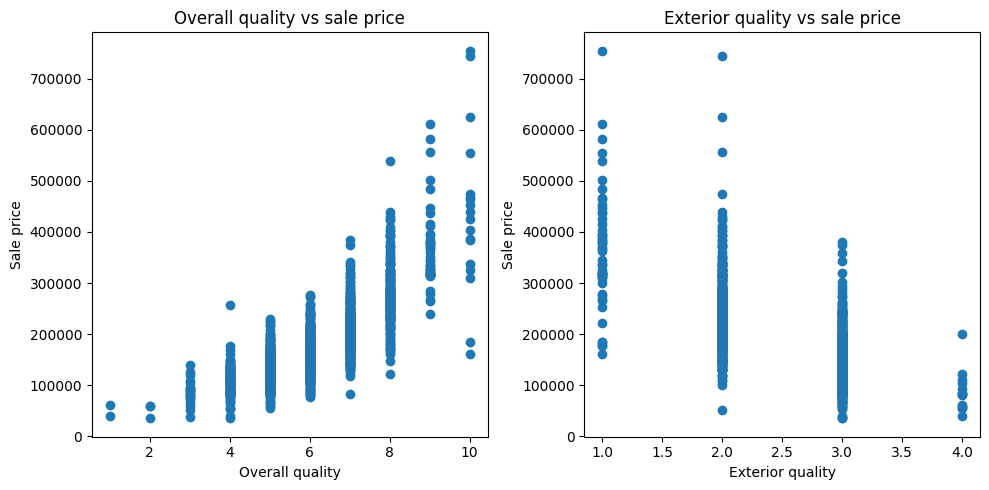

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(train_csv['OverallQual'], train_csv['SalePrice'])
plt.title("Overall quality vs sale price")
plt.ylabel('Sale price')
plt.xlabel("Overall quality")
plt.subplot(122)
plt.scatter(train_csv['ExterQual'], train_csv['SalePrice'])
plt.title("Exterior quality vs sale price")
plt.ylabel('Sale price')
plt.xlabel("Exterior quality")

plt.tight_layout()

Finally we can also check how all features are correlated to one another. This is done through the Pearson Correlation Matrix. Here we can 

# 4. Fitting a linear model to the dataset



## 4.1 Applying principal component analysis

In [10]:
# apply pca to the dataset

pca = sklearn.decomposition.PCA(n_components=79)

x_train = pca.fit_transform(train_x)
x_test = pca.transform(test_x)

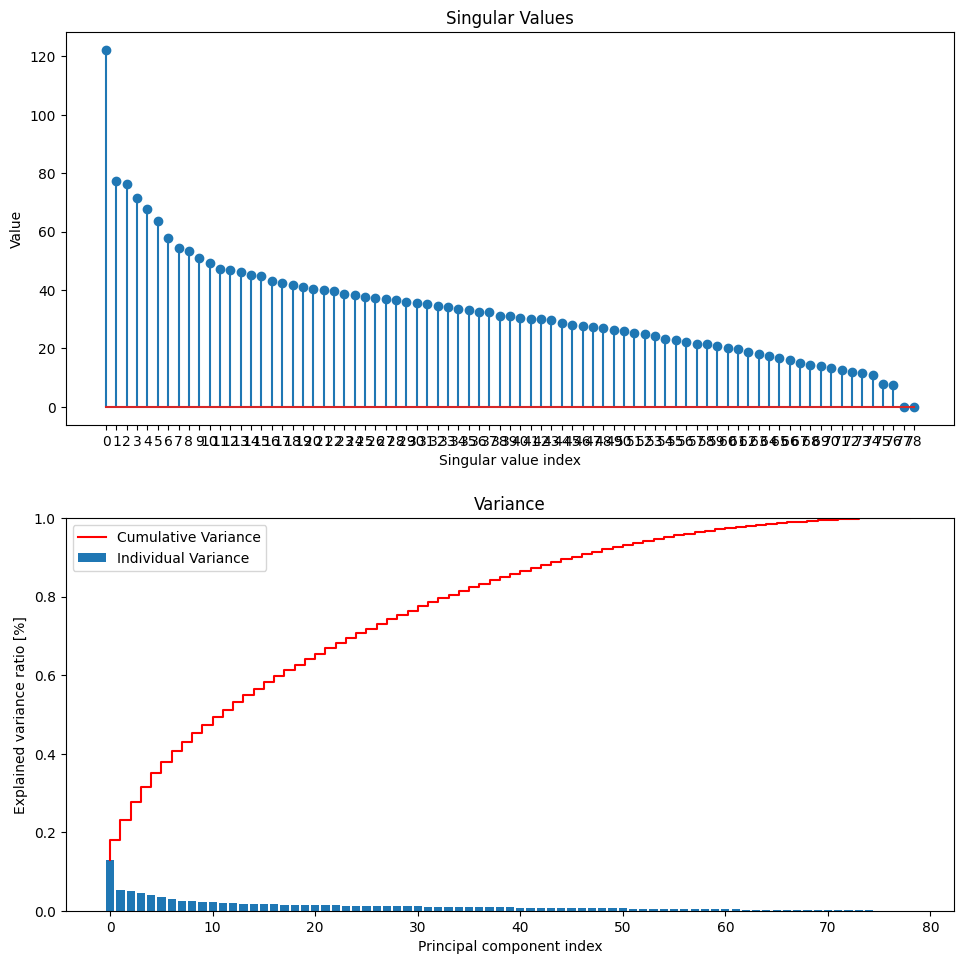

In [11]:
singular_values = pca.singular_values_
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
#print(cumulative_explained_variance_ratio)

# plotting the singular values and the histogram of the explained varainces
fig = plt.figure(figsize=(10,10))
plt.subplot(211)
plt.stem(singular_values)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xticks(np.arange(0,len(singular_values),1))
plt.title("Singular Values")
plt.ylabel("Value")
plt.xlabel("Singular value index")
plt.subplot(212)
plt.bar(np.arange(0,len(explained_variance_ratio[:]),1), explained_variance_ratio[:], label="Individual Variance")
plt.step(np.arange(0,len(cumulative_explained_variance_ratio[:]),1),cumulative_explained_variance_ratio[:], label="Cumulative Variance", color='r')
# plt.xticks([0,1,2,3,4])
plt.title("Variance")
plt.ylabel("Explained variance ratio [%]")
plt.xlabel("Principal component index")
plt.legend()
plt.ylim((0,1))
fig.tight_layout(pad=2)
plt.show()

## 4.2 Creating a deep learning model



In [12]:
Layer0 = 79 ## n PCA componente

layer1 = 79
layer2 = 40
layer3 = 30

LayerOut = 1

Inputs  = keras.Input(shape=(Layer0, ))
dense = keras.layers.Dense(layer1, activation= 'relu')
x = dense(Inputs)
x = keras.layers.Dense(layer2, activation= 'relu')(x)
x = keras.layers.Dense(layer3, activation= 'relu')(x)

Outputs = keras.layers.Dense(LayerOut)(x)

model = keras.Model(inputs=Inputs, outputs=Outputs, name = 'housingModel')

In [13]:
model.summary()


Model: "housingModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 79)             │         6,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,781 (42.11 KB)

 Trainable params: 10,781 (42.11 KB)

 Non-trainable params: 0 (0.00 B)

# N. References

- Predicting House Prices (Keras - ANN), Tomas Mantero, https://www.kaggle.com/code/tomasmantero/predicting-house-prices-keras-ann/notebook
- 